## Gradient Boosting model for classifying endangered languages
**Summary** 

The notebook focuses on training, implementing, and tuning a gradient boosting model to predict language endangerment levels based on different socioeconomic features. 

In [52]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import classification_report, f1_score, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.ensemble import (GradientBoostingClassifier)
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import itertools
from sklearn.metrics import log_loss
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder

In [30]:
# Load and inspect the final_dataset
df = pd.read_parquet('Data Cleaning/final_dataset2.parquet')

In [31]:
comma_separated_names = ','.join(df['official_name'].astype(str))

# Write to file
with open('official_names.txt', 'w') as file:
    file.write(comma_separated_names)

In [32]:
# Create a new column with combined classes
df_modified = df.copy()

def combine_endangered_classes(level):
    if level in ['Severely Endangered', 'Critically Endangered']:
        return 'Highly Endangered'
    elif level in ['Threatened', 'Vulnerable', 'At risk']:
        return 'At Risk'
    else:
        return level

df_modified['level_combined'] = df_modified['level'].apply(combine_endangered_classes)

In [33]:
df_modified

,official_name,level,speakers,country,official,regional,minority,national,widely_spoken,country_count,max_urbanization,max_internet_use,level_combined
0,!Xun,Vulnerable,18000,South Africa;Namibia;Angola,0,0,0,0,0,3,68.819,75.7,At Risk
1,(Lower) Tanana,Critically Endangered,25,United States,0,0,0,0,0,1,83.298,93.1,Highly Endangered
2,A'ingae,Vulnerable,1500,Colombia;Ecuador,0,0,0,0,0,2,82.354,77.3,At Risk
3,Aasáx,Extinct,0,Tanzania,0,0,0,0,0,1,37.409,29.1,Extinct
4,Abaga,Critically Endangered,5,Papua New Guinea,0,0,0,0,0,1,13.723,24.1,Highly Endangered
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2865,Tiv,Not Endangered,5000000,"Peru;Venezuela, RB",0,1,1,0,0,2,88.438,79.5,Not Endangered
2866,Tatar,Not Endangered,4800000,Poland;Romania;Ukraine,0,1,2,0,0,3,70.095,89.2,Not Endangered
2867,Shan,Not Endangered,4700000,Ethiopia;Myanmar;Zimbabwe,1,1,0,1,0,3,32.517,58.5,Not Endangered
2868,Lao,Not Endangered,4700000,Lao PDR;Viet Nam,1,0,1,0,0,2,39.480,78.1,Not Endangered


In [34]:
def prepare_features_with_engineering(df):
    """
    Prepare features with additional feature engineering
    """
    # Create copy to avoid modifying original
    df_feat = df.copy()
    
    # Ensure numeric columns are properly typed
    numeric_cols = ['speakers', 'official', 'regional', 'minority', 'national', 
                   'widely_spoken', 'country_count', 'max_urbanization', 
                   'max_internet_use']
    
    for col in numeric_cols:
        if col in df_feat.columns:
            df_feat[col] = pd.to_numeric(df_feat[col], errors='coerce').fillna(0)
    
    # Add ratio features
    df_feat['urbanization_internet_product'] = df_feat['max_urbanization'] * df_feat['max_internet_use']
    df_feat['official_national_sum'] = df_feat['official'] + df_feat['national']
    df_feat['minority_regional_sum'] = df_feat['minority'] + df_feat['regional']
    
    # Log transform skewed features
    df_feat['log_speakers'] = np.log1p(df_feat['speakers'])
    
    # Interaction features
    df_feat['speakers_urbanization'] = df_feat['speakers'] * df_feat['max_urbanization']
    df_feat['speakers_internet'] = df_feat['speakers'] * df_feat['max_internet_use']
    
    # Replace any infinities or NaNs
    df_feat = df_feat.replace([np.inf, -np.inf], 0)
    df_feat = df_feat.fillna(0)
    
    return df_feat

In [35]:
def handle_class_imbalance(X_train, y_train, method='class_weight'):
    """
    Handle class imbalance using available methods
    """
    try:
        from imblearn.over_sampling import SMOTE, ADASYN
        from imblearn.combine import SMOTETomek
        HAS_IMBALANCED_LEARN = True
    except ImportError:
        HAS_IMBALANCED_LEARN = False
        print("imbalanced-learn not available. Install with: pip install imbalanced-learn")

    if HAS_IMBALANCED_LEARN and method == 'smote':
        smote = SMOTE(random_state=42, k_neighbors=min(5, min(np.bincount(y_train)) - 1))
        return smote.fit_resample(X_train, y_train)
    else:
        # Return original data if SMOTE not available
        return X_train, y_train

## Base Gradient Boosting Model (no tuning)
Granular levels:
- Train Accuracy: 0.976
- Validation Accuracy: 0.697
- Test Accuracy: 0.721
- *Notes:* Large gap between training and validation/test accuracies indicates overfitting.

Grouped levels:
- Train Accuracy: 0.986
- Validation Accuracy: 0.873
- Test Accuracy: 0.861
- *Notes:* Overfitting still exists, as indicated by the substantial gap between train and validation accuracy, but it decreases significantly by using the grouped levels instead of the granular levels.

In [36]:
def train_gradient_boosting_model(dataframe, target_column):
    """
    Train Gradient Boosting model (sklearn version)
    """
    print("Training Gradient Boosting model...")
    
    # Prepare features
    df_feat = prepare_features_with_engineering(dataframe)
    
    # Select features
    feature_cols = list(df_feat.columns[4:12]) + [
        'urbanization_internet_product', 
        'official_national_sum', 'minority_regional_sum',
        'log_speakers',
        'speakers_urbanization', 'speakers_internet'
    ]
    
    X = df_feat[feature_cols]
    y = df_feat[target_column]

    # Encode target variable 'y' into numeric labels
    le = LabelEncoder()
    y = le.fit_transform(y)
    
    # Split into train (80) and test (20)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Then split train into train (60) and val (20)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.25, stratify=y_train, random_state=42
    )
    
    # Scale features
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_val_scaled = scaler.transform(X_val)

    # Handle class imbalance
    X_train_balanced, y_train_balanced = handle_class_imbalance(X_train_scaled, y_train, method='smote')
    
    # Train Gradient Boosting
    gb_model = GradientBoostingClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    )
    
    gb_model.fit(X_train_balanced, y_train_balanced)
    
    # Predictions
    y_train_pred = gb_model.predict(X_train_balanced)
    train_accuracy = accuracy_score(y_train_balanced, y_train_pred)
    y_pred = gb_model.predict(X_test_scaled)
    test_accuracy = accuracy_score(y_test, y_pred)
    y_val_pred = gb_model.predict(X_val_scaled)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    
    print(f"Train Accuracy: {train_accuracy:.3f}")
    print(f"Validation Accuracy: {val_accuracy:.3f}")
    print(f"Test Accuracy: {test_accuracy:.3f}")

    print("\nValidation Classification Report:")
    print(classification_report(y_val, y_val_pred))
    print("\nTest Classification Report:")
    print(classification_report(y_test, y_pred))
    
    return gb_model, scaler, feature_cols, X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, X_train_balanced, y_train_balanced, X_test

In [37]:
# Granular dataset
gb_model1, scaler1, features1, X_train_scaled1, X_val_scaled1, X_test_scaled1, y_train1, y_val1, y_test1, X_train_balanced1, y_train_balanced1, X_test1 = train_gradient_boosting_model(df, 'level')

Training Gradient Boosting model...
Train Accuracy: 0.976
Validation Accuracy: 0.697
Test Accuracy: 0.721

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.69      0.69        13
           1       0.79      0.68      0.73        77
           2       0.72      0.68      0.70       130
           3       0.97      0.97      0.97        35
           4       1.00      1.00      1.00        18
           5       0.45      0.43      0.44        67
           6       0.68      0.81      0.74       149
           7       0.63      0.58      0.60        85

    accuracy                           0.70       574
   macro avg       0.74      0.73      0.73       574
weighted avg       0.70      0.70      0.69       574


Test Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.69      0.55        13
           1       0.80      0.78      0.79        77
           2    

In [38]:
# Grouped dataset
gb_model2, scaler2, features2, X_train_scaled2, X_val_scaled2, X_test_scaled2, y_train2, y_val2, y_test2, X_train_balanced2, y_train_balanced2, X_test2 = train_gradient_boosting_model(df_modified, 'level_combined')

Training Gradient Boosting model...
Train Accuracy: 0.986
Validation Accuracy: 0.873
Test Accuracy: 0.861

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       247
           1       0.79      0.71      0.75       131
           2       1.00      0.97      0.99        34
           3       0.86      0.92      0.89       144
           4       1.00      1.00      1.00        18

    accuracy                           0.87       574
   macro avg       0.91      0.90      0.90       574
weighted avg       0.87      0.87      0.87       574


Test Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       247
           1       0.79      0.73      0.76       131
           2       1.00      0.97      0.99        34
           3       0.85      0.84      0.84       144
           4       1.00      1.00      1.00        18

    accuracy   

## Tuned Gradient Boosting Model
The tuned version involves optimizing four hyperparameters-n_estimators, max_depth, learning_rate, and subsample-to see which combinations most improve model performance.

Granular levels:
- Train accuracy: 0.844
- Validation accuracy: 0.770
- Test accuracy: 0.779
- Log loss: 0.776

Grouped levels:
- Train accuracy: 0.918
- Validation accuracy: 0.901
- Test accuracy: 0.883
- Log loss: 0.366

In [39]:
def gboost_tuner(param_dict, X_train, y_train, X_val, y_val, X_test_scaled, y_test):
    best_model = None
    best_score = 0
    best_train = 0
    best_loss = float('inf')
    best_params = {}

    for est, depth, lr, ss in itertools.product(
        param_dict['n_estimators'],
        param_dict['max_depth'],
        param_dict['learning_rate'],
        param_dict['subsample']
    ):
        model = GradientBoostingClassifier(
            n_estimators=est,
            max_depth=depth,
            learning_rate=lr,
            subsample=ss,
            min_samples_split=5,
            min_samples_leaf=2,
            random_state=42
        )

        model.fit(X_train, y_train)

        # Train accuracy
        train_preds = model.predict(X_train)
        train_acc = accuracy_score(y_train, train_preds)

        # Validation accuracy
        val_preds = model.predict(X_val)
        val_acc = accuracy_score(y_val, val_preds)
        val_proba = model.predict_proba(X_val)
        val_loss = log_loss(y_val, val_proba)
        print(f"Trying: est={est}, depth={depth}, lr={lr}, ss={ss} --> val_acc={val_acc:.3f}, val_loss={val_loss:.3f}, train_acc={train_acc:.3f}")

        # Get best model
        if val_acc > best_score:
            best_train = train_acc
            best_score = val_acc
            best_loss = val_loss
            best_model = model
            best_params = {
                'n_estimators': est,
                'max_depth': depth,
                'learning_rate': lr,
                'subsample': ss
            }

    best_test = accuracy_score(y_test, best_model.predict(X_test_scaled))
    print(f"Train accuracy: {best_train:.3f}")
    print(f"Validation accuracy: {best_score:.3f}")
    print(f"Test accuracy: {best_test:.3f}")
    print(f"Log loss: {best_loss:.3f}")
    print(f"Best hyperparameters: {best_params}")
    return best_model, best_score, best_loss, best_params

In [40]:
# Granular levels
tuning_dict = {
    'n_estimators': [50, 100, 200],
    'max_depth': [1, 3, 5],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.6, 0.8]
}

best_model1, best_score1, best_loss1, best_params1 = gboost_tuner(
    tuning_dict,
    X_train_balanced1,
    y_train_balanced1,
    X_val_scaled1,
    y_val1,
    X_test_scaled1,
    y_test1
)

Trying: est=50, depth=1, lr=0.05, ss=0.6 --> val_acc=0.744, val_loss=0.917, train_acc=0.823
Trying: est=50, depth=1, lr=0.05, ss=0.8 --> val_acc=0.744, val_loss=0.920, train_acc=0.823
Trying: est=50, depth=1, lr=0.1, ss=0.6 --> val_acc=0.746, val_loss=0.800, train_acc=0.830
Trying: est=50, depth=1, lr=0.1, ss=0.8 --> val_acc=0.747, val_loss=0.799, train_acc=0.830
Trying: est=50, depth=3, lr=0.05, ss=0.6 --> val_acc=0.742, val_loss=0.791, train_acc=0.840
Trying: est=50, depth=3, lr=0.05, ss=0.8 --> val_acc=0.744, val_loss=0.796, train_acc=0.842
Trying: est=50, depth=3, lr=0.1, ss=0.6 --> val_acc=0.754, val_loss=0.759, train_acc=0.871
Trying: est=50, depth=3, lr=0.1, ss=0.8 --> val_acc=0.754, val_loss=0.759, train_acc=0.869
Trying: est=50, depth=5, lr=0.05, ss=0.6 --> val_acc=0.744, val_loss=0.800, train_acc=0.886
Trying: est=50, depth=5, lr=0.05, ss=0.8 --> val_acc=0.744, val_loss=0.804, train_acc=0.892
Trying: est=50, depth=5, lr=0.1, ss=0.6 --> val_acc=0.720, val_loss=0.821, train_acc

In [41]:
# Grouped levels
best_model2, best_score2, best_loss2, best_params2 = gboost_tuner(
    tuning_dict,
    X_train_balanced2,
    y_train_balanced2,
    X_val_scaled2,
    y_val2,
    X_test_scaled2,
    y_test2
)

Trying: est=50, depth=1, lr=0.05, ss=0.6 --> val_acc=0.890, val_loss=0.512, train_acc=0.896
Trying: est=50, depth=1, lr=0.05, ss=0.8 --> val_acc=0.890, val_loss=0.513, train_acc=0.896
Trying: est=50, depth=1, lr=0.1, ss=0.6 --> val_acc=0.890, val_loss=0.398, train_acc=0.895
Trying: est=50, depth=1, lr=0.1, ss=0.8 --> val_acc=0.889, val_loss=0.402, train_acc=0.896
Trying: est=50, depth=3, lr=0.05, ss=0.6 --> val_acc=0.892, val_loss=0.398, train_acc=0.905
Trying: est=50, depth=3, lr=0.05, ss=0.8 --> val_acc=0.890, val_loss=0.402, train_acc=0.904
Trying: est=50, depth=3, lr=0.1, ss=0.6 --> val_acc=0.892, val_loss=0.370, train_acc=0.922
Trying: est=50, depth=3, lr=0.1, ss=0.8 --> val_acc=0.901, val_loss=0.366, train_acc=0.918
Trying: est=50, depth=5, lr=0.05, ss=0.6 --> val_acc=0.894, val_loss=0.384, train_acc=0.932
Trying: est=50, depth=5, lr=0.05, ss=0.8 --> val_acc=0.892, val_loss=0.383, train_acc=0.932
Trying: est=50, depth=5, lr=0.1, ss=0.6 --> val_acc=0.894, val_loss=0.373, train_acc

In [43]:
def plot_feature_importance(model, feature_names, model_name, 
                            X_test=None, y_test=None, 
                            scaler=None, use_permutation=False):
    """
    Plot top 5 feature importances for a given model using a neutral color.
    """
    plt.figure(figsize=(8, 3))  # smaller for top 5
    
    # Compute importances
    if use_permutation and X_test is not None and y_test is not None:
        from sklearn.inspection import permutation_importance
        
        X_test_scaled = scaler.transform(X_test) if scaler is not None else X_test
        perm_importance = permutation_importance(
            model, X_test_scaled, y_test, n_repeats=10, random_state=42
        )
        importances = perm_importance.importances_mean
    else:
        importances = model.feature_importances_
    
    # Build DataFrame and select top 5
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False).head(5)
    
    # Reverse for horizontal bar plot (largest at top)
    importance_df = importance_df[::-1]
    
    # Plot horizontal bar chart
    bars = plt.barh(importance_df['feature'], importance_df['importance'], color='gray')
    
    # Add value labels
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
                 f'{width:.3f}', va='center', fontsize=7)
    
    plt.xlabel('Feature Importance', fontsize=10)
    plt.title(f'{model_name} - Top 5 Feature Importances', fontsize=10)
    plt.tight_layout()
    plt.show()
    
    # Print top 5 features
    print(f"\nTop 5 Features for {model_name}:")
    print(importance_df.sort_values('importance', ascending=False).to_string(index=False))

def plot_all_feature_importances(gb_model, features):
    """
    Plot feature importances for all models
    """
    print("=" * 60)
    print("FEATURE IMPORTANCE ANALYSIS")
    print("=" * 60)
    
    # 1. Gradient Boosting
    if gb_model is not None:
        plot_feature_importance(gb_model, features, "Gradient Boosting")
    

def create_feature_importance_comparison(gb_model, features):
    """
    Create a comparison heatmap of feature importances across tree-based models
    """
    models_with_importance = []
    importance_matrix = []
    
    if gb_model is not None and hasattr(gb_model, 'feature_importances_'):
        models_with_importance.append('Gradient Boosting')
        importance_matrix.append(gb_model.feature_importances_)
    
    if len(importance_matrix) > 1:
        # Create heatmap
        plt.figure(figsize=(12, 8))
        
        # Normalize importances for better comparison
        importance_matrix = np.array(importance_matrix)
        importance_matrix = importance_matrix / importance_matrix.sum(axis=1, keepdims=True)
        
        # Create dataframe
        importance_df = pd.DataFrame(importance_matrix.T, 
                                   index=features,
                                   columns=models_with_importance)
        
        # Sort by average importance
        importance_df['Average'] = importance_df.mean(axis=1)
        importance_df = importance_df.sort_values('Average', ascending=False)
        importance_df = importance_df.drop('Average', axis=1)
        
        # Plot heatmap
        sns.heatmap(importance_df.head(20).T, cmap='YlOrRd', annot=True, fmt='.3f', 
                    cbar_kws={'label': 'Normalized Importance'})
        plt.title('Feature Importance Comparison Across Models (Top 20)', 
                  fontsize=14, fontweight='bold')
        plt.xlabel('Features', fontsize=12)
        plt.ylabel('Models', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

def analyze_feature_correlations(df, features, top_n=10):
    """
    Analyze correlations between top features
    """
    # Prepare features
    df_feat = prepare_features_with_engineering(df)
    
    # Get feature data
    feature_data = df_feat[features]
    
    # Calculate correlation matrix
    corr_matrix = feature_data.corr()
    
    # Plot correlation heatmap for top features
    plt.figure(figsize=(10, 8))
    
    # Select top features based on variance
    top_features = feature_data.var().nlargest(top_n).index.tolist()
    
    sns.heatmap(corr_matrix.loc[top_features, top_features], 
                annot=True, fmt='.2f', cmap='coolwarm', center=0,
                square=True, linewidths=1)
    plt.title(f'Feature Correlation Matrix (Top {top_n} by Variance)', 
              fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


FEATURE IMPORTANCE ANALYSIS


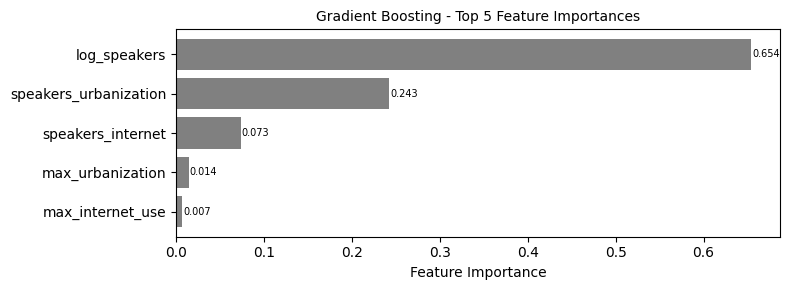


Top 5 Features for Gradient Boosting:
              feature  importance
         log_speakers    0.654193
speakers_urbanization    0.242723
    speakers_internet    0.073291
     max_urbanization    0.014269
     max_internet_use    0.007030


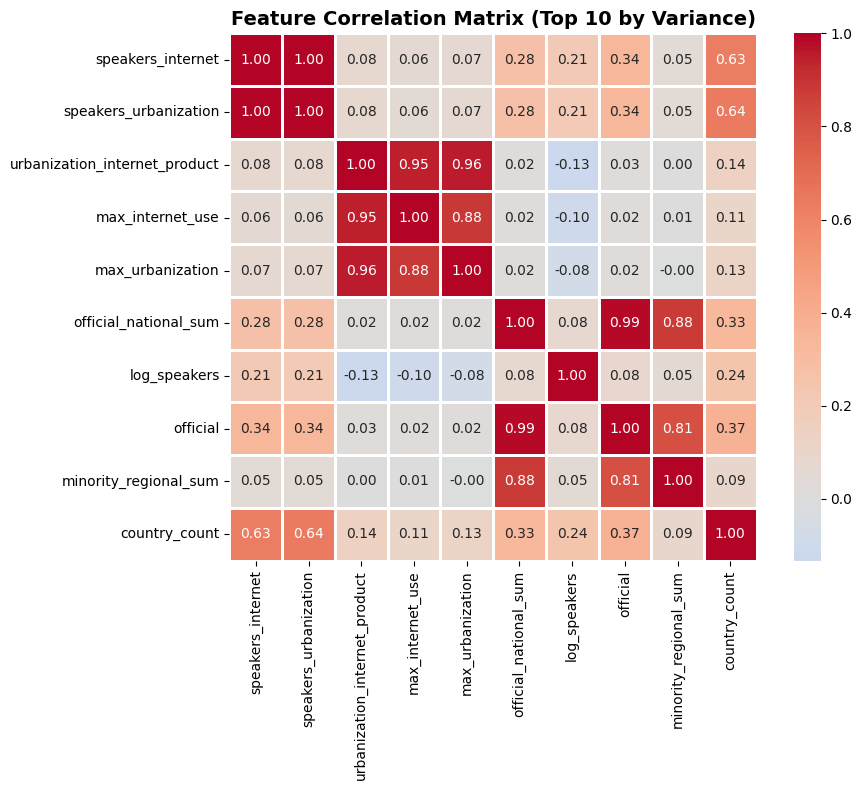

In [44]:
# Granular levels
plot_all_feature_importances(best_model1, features1)

# Comparison heatmap:
create_feature_importance_comparison(best_model1, features1)

# Feature correlation analysis:
analyze_feature_correlations(df, features1)

FEATURE IMPORTANCE ANALYSIS


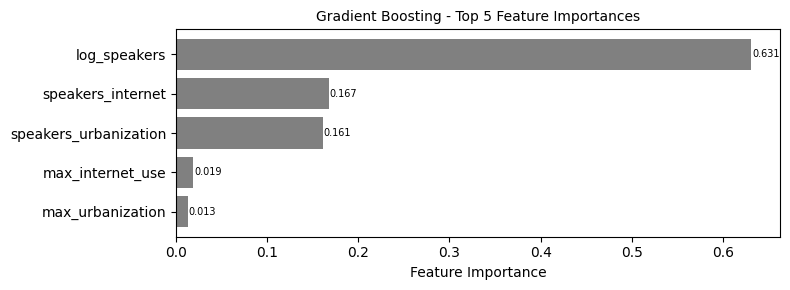


Top 5 Features for Gradient Boosting:
              feature  importance
         log_speakers    0.631097
    speakers_internet    0.167321
speakers_urbanization    0.161036
     max_internet_use    0.018934
     max_urbanization    0.012786


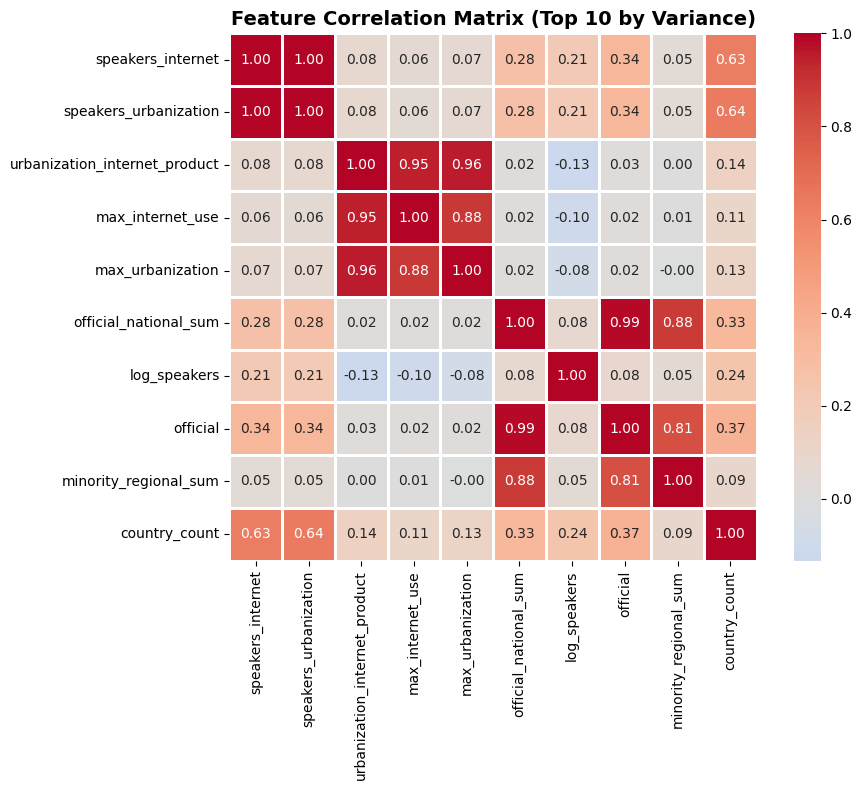

In [45]:
# Grouped levels
plot_all_feature_importances(best_model2, features2)

# Comparison heatmap:
create_feature_importance_comparison(best_model2, features2)

# Feature correlation analysis:
analyze_feature_correlations(df_modified, features2)

## Subgroup Evaluation
The following code evaluates the performance of best_model2 (the tuned model with broader endangerment level groupings) on legally recognized vs. non-legally recognized languages.
Here, a language is considered legally recognized if it is classified as Official or National in at least one country. From the results, we see that the model performs better on legally recognized countries:
- Not Legally Recognized: 0.880
- Legally Recognized: 0.960

Overall Test Accuracy: 0.883

Subgroup Test Accuracy:
Not Legally Recognized: 0.880
Legally Recognized: 0.960


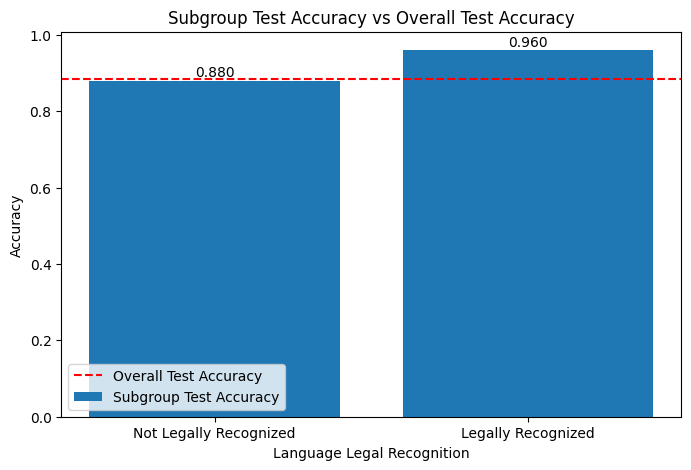

In [46]:
# Convert X_test2 to DataFrame with column names
feature_cols = [
    'official', 'regional', 'minority', 'national', 'widely_spoken',
    'country_count', 'max_urbanization', 'max_internet_use',
    'urbanization_internet_product', 'official_national_sum',
    'minority_regional_sum', 'log_speakers', 'speakers_urbanization',
    'speakers_internet'
]
X_test2 = pd.DataFrame(X_test2, columns=feature_cols)

# Create subgroup column: 1 if language is an official or national language in 1+ countries
legally_recognized = (X_test2['official_national_sum'] >= 1).astype(int)

# Overall test accuracy
y_test_pred2 = best_model2.predict(X_test_scaled2)
test_accuracy = accuracy_score(y_test2, y_test_pred2)

# Subgroup accuracies
acc_0 = accuracy_score(
    y_test2[legally_recognized == 0],
    y_test_pred2[legally_recognized == 0]
)
acc_1 = accuracy_score(
    y_test2[legally_recognized == 1],
    y_test_pred2[legally_recognized == 1]
)

# Print accuracies
print(f"Overall Test Accuracy: {test_accuracy:.3f}")
print("\nSubgroup Test Accuracy:")
print(f"Not Legally Recognized: {acc_0:.3f}")
print(f"Legally Recognized: {acc_1:.3f}")

# Bar chart with descriptive x-axis labels
subgroup_eval = pd.Series(
    {'Not Legally Recognized': acc_0, 'Legally Recognized': acc_1}
)
plt.figure(figsize=(8, 5))
plt.bar(subgroup_eval.index, subgroup_eval.values, label='Subgroup Test Accuracy')
plt.text(0, acc_0+0.01, f'{acc_0:.3f}', ha='center')
plt.text(1, acc_1+0.01, f'{acc_1:.3f}', ha='center')
plt.axhline(y=test_accuracy, color='red', linestyle='--', label='Overall Test Accuracy')
plt.xlabel('Language Legal Recognition')
plt.ylabel('Accuracy')
plt.title('Subgroup Test Accuracy vs Overall Test Accuracy')
plt.legend()
plt.show()

In [48]:
recognized_count = len(df[(df['official'] >= 1) | (df['national'] >= 1)])
unrecognized_count = len(df[(df['official'] < 1) & (df['national'] < 1)])

print(f"Recognized: {recognized_count}")
print(f"Unrecognized: {unrecognized_count}")
print(f"Total: {recognized_count + unrecognized_count}")

Recognized: 147
Unrecognized: 2723
Total: 2870


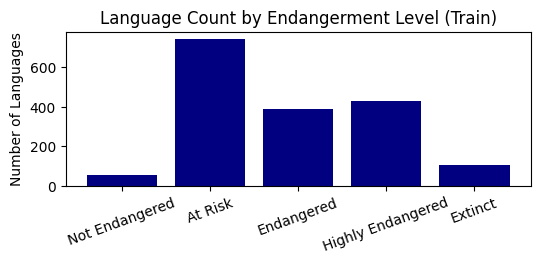

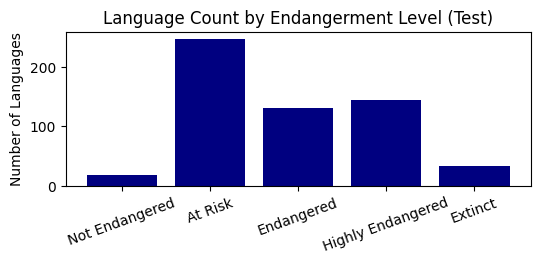

In [59]:
# Map numeric labels to text
label_map = {
    0: "At Risk",
    1: "Endangered",
    2: "Extinct",
    3: "Highly Endangered",
    4: "Not Endangered"
}

# Reorder for your preferred order
desired_order = [
    "Not Endangered",
    "At Risk",
    "Endangered",
    "Highly Endangered",
    "Extinct"
]

def plot_class_distribution(y, title):
    counts = pd.Series(y).value_counts().sort_index()
    df_counts = pd.DataFrame({
        "label": [label_map[i] for i in counts.index],
        "count": counts.values
    })
    
    df_counts = df_counts.set_index("label").reindex(desired_order).reset_index()

    # Plot
    plt.figure(figsize=(6, 2))
    plt.bar(df_counts["label"], df_counts["count"], color="navy")
    plt.xticks(rotation=20)
    plt.ylabel("Number of Languages")
    plt.title(title)
    plt.show()

# Example usage:
plot_class_distribution(y_train2, "Language Count by Endangerment Level (Train)")
plot_class_distribution(y_test2, "Language Count by Endangerment Level (Test)")

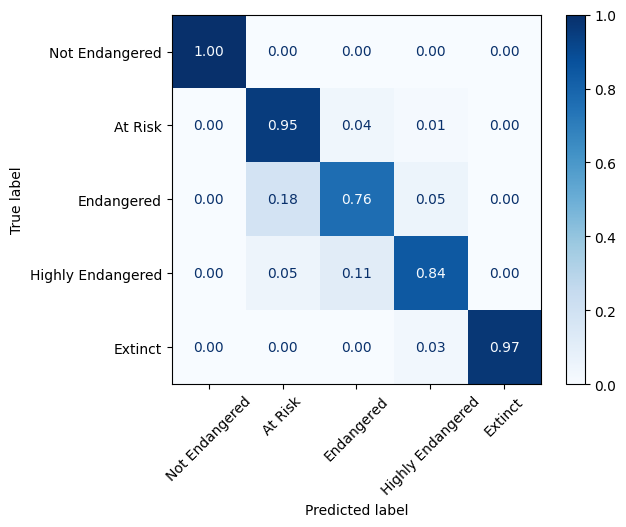

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_test2, y_test_pred2)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Map class names to integers
class_to_int = {v: k for k, v in label_map.items()}

# Get index order for the confusion matrix
order_idx = [class_to_int[label] for label in desired_order]

# Reorder confusion matrix
cm_reordered = cm_normalized[np.ix_(order_idx, order_idx)]

# Display confusion matrix with class names in desired order
disp = ConfusionMatrixDisplay(confusion_matrix=cm_reordered, display_labels=desired_order)
disp.plot(cmap="Blues", values_format='.2f', xticks_rotation=45)